In [1]:
import re
import math
import time
import json
import csv
import pickle
# import tweepy
import requests
import pprint
import numpy as np
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.stats import chisquare
from collections import defaultdict, Counter

In [2]:
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

In [3]:
# data_root = '/shared/0/datasets/mag/Cell/Retraction/'
data_root = '/home/haopeng/Data/Retraction/'
altmetric_start_date = datetime.strptime('2011-06-10', '%Y-%m-%d')
altmetric_end_date = datetime.strptime('2019-10-08', '%Y-%m-%d')
day = 24*3600

In [4]:
# this correction is done manually

blog_df = pd.read_csv(data_root + 'blog_mentions_correction.csv', header = 0)
blog_set = set(blog_df.loc[~blog_df.maybe_news.isnull(), 'blog_name'])

def correct_blogs(data, error_blogs):
    for xid, paper in data.items():
        if 'blogs' in paper['posts']:
            blogs_li = paper['posts']['blogs']
            news_li = []
            if 'news' in paper['posts']:
                news_li = paper['posts']['news']
            blogs_li_new = []
            for item in blogs_li:
                try:
                    if item['author']['name'] in error_blogs:
                        news_li.append(item)
                    else:
                        blogs_li_new.append(item)
                except:
                    pass
            paper['posts']['news'] = news_li
            paper['posts']['blogs'] = blogs_li_new
    return data

In [169]:
outlets = pd.read_csv(data_root+'all_news_sources.csv', header=0)
top_outlets = set(outlets.loc[outlets.Include == 'y', 'Mention source'])

In [170]:
len(top_outlets)

27

### Load tweets

In [272]:
# this file is produced at the beginning part of `5_critical_tweet_label.ipynb`, which processes tweets for 
# both retracted and control papers. At this point, we haven't matched control papers yet, but you can still run 
# that code first to get processed tweets for retracted papers.

with open(data_root + 'tweets_processed.pickle', 'rb') as ofile:
    tid_date, tid_text, tid_author, tid_follow_cn, retweet_org_ids = pickle.load(ofile)
    
for tid, tdate in tid_date.items():
    tdate = tdate.strftime("%Y-%m-%dT%H:%M:%S")
    tid_date[tid] = tdate

In [273]:
len(tid_text)

159408

In [534]:
len(tid_follow_cn)

159408

In [274]:
len(retweet_org_ids)

87670

### Load uncertainty tweets

In [493]:
# this file is produced in `5_critical_tweet_label.ipynb`. You can skip this block first to create the retract dataframe,
# which will be used in `5_critical_tweet_label.ipynb`. Then you can go back here to run this code block and recreate retract dataframe.

cand_tweets_df = pd.read_csv(data_root + 'cand_uncertain_tweets_mvotes.csv', quoting=csv.QUOTE_ALL, header=0, dtype={'tid': 'str'})

In [487]:
# treating ambiguous tweets as positive ones.
# cand_tweets_df = pd.read_csv(data_root + 'cand_uncertain_tweets_mvotes_bar.csv', quoting=csv.QUOTE_ALL, header=0, dtype={'tid': 'str'})

In [494]:
uncertain_tids = cand_tweets_df.loc[cand_tweets_df.majority_vote == 1, 'tid'].tolist()

In [495]:
len(uncertain_tids)

1203

In [490]:
len(uncertain_tids)

1747

### For data description only 

In [450]:
df = pd.read_excel(data_root+'RetractionWatchData2020.xlsx', sheet_name='GridViewExport (22)', header=0, index_col = None)
df['pub_year_rw'] = df.OriginalPaperDate.apply(lambda dtt: dtt.year if isinstance(dtt, dt.date) else -1)

In [451]:
len(df)

21850

In [452]:
df.OriginalPaperDOI.value_counts()

unavailable                         777
Unavailable                           9
10.1007/s11042-017-5385-3             3
10.1093/carcin/bgt251                 2
10.1677/JOE-07-0195                   2
                                   ... 
10.1109/ICIECS.2010.5677772           1
10.1016/j.surfcoat.2012.07.049        1
10.1109/ICIECS.2010.5678123           1
10.1152/ajpcell.00349.2001            1
10.1111/j.1467-8535.2009.01033.x      1
Name: OriginalPaperDOI, Length: 16462, dtype: int64

In [453]:
df_doi_miss = df.loc[(df.OriginalPaperDOI.isnull()) | (df.OriginalPaperDOI == 'unavailable') | (df.OriginalPaperDOI == 'Unavailable')]

In [454]:
len(df_doi_miss)

5341

In [455]:
df_doi_miss.ArticleType.value_counts()

Conference Abstract/Paper;                     4063
Research Article;                               818
Review Article;                                 162
Clinical Study;                                 146
Case Report;                                     59
Book Chapter/Reference Work;                     16
Commentary/Editorial;                            13
Letter;                                           9
Newspaper/Magazine Article;                       8
Case Report;Conference Abstract/Paper;            6
Meta-Analysis;                                    6
Clinical Study;Research Article;                  6
Article in Press;Research Article;                4
Article in Press;                                 4
Clinical Study;Conference Abstract/Paper;         3
Case Report;Review Article;                       3
Guideline;                                        3
Technical Report/White Paper;                     2
Conference Abstract/Paper;Meta-Analysis;          1
Retracted Ar

In [457]:
df_doi_miss.pub_year_rw.value_counts()

 2010    2355
 2011    1209
 2009     612
 2015     107
 2008      89
 2014      76
 2018      67
 2013      62
 2012      58
 2005      56
 2006      55
 2016      47
 2007      45
 2017      38
 2004      36
 2003      34
 2001      32
 1998      32
 1997      26
 2002      26
 1999      25
 2000      24
 1990      23
 1994      22
 2019      21
 1992      20
 1991      20
 1996      18
 1993      13
 2020      12
 1989      10
 1995       9
-1          8
 1987       8
 1988       7
 1983       6
 1981       6
 1985       5
 1986       5
 1984       4
 1982       2
 1978       2
 1923       2
 1979       2
 1926       1
 1955       1
 1971       1
 1980       1
 1976       1
Name: pub_year_rw, dtype: int64

In [466]:
df = df.loc[df.OriginalPaperDate.apply(lambda dtt: True if isinstance(dtt, dt.date) else False)]

In [468]:
len(df)

21800

In [469]:
df = df.loc[df.OriginalPaperDate.apply(lambda dttt: (dttt-altmetric_start_date).total_seconds() > 0)]

In [470]:
len(df)

9201

In [472]:
df.OriginalPaperDate

0        2020-04-05 00:00:00
1        2020-05-01 00:00:00
2        2019-05-24 00:00:00
3        2020-05-22 00:00:00
4        2020-02-06 00:00:00
                ...         
20800    2015-04-01 00:00:00
21131    2014-02-14 00:00:00
21181    2013-01-15 00:00:00
21265    2014-05-03 00:00:00
21657    2013-12-01 00:00:00
Name: OriginalPaperDate, Length: 9201, dtype: object

In [473]:
df = df.loc[~df['OriginalPaperDOI'].isna()]
df = df.loc[~df['OriginalPaperDOI'].isin(['Unavailable', 'unavailable'])]
df.index = range(len(df))
df.OriginalPaperDOI = df['OriginalPaperDOI'].apply(lambda x: x.lower())

In [474]:
len(df)

8434

### Clean dup dois in Watch data

In [506]:
df = pd.read_excel(data_root+'RetractionWatchData2020.xlsx', sheet_name='GridViewExport (22)', header=0, index_col = None)


In [507]:
len(df)

21850

In [508]:
df = df.loc[~df['OriginalPaperDOI'].isna()]
df = df.loc[~df['OriginalPaperDOI'].isin(['Unavailable', 'unavailable'])]
df.index = range(len(df))
df.OriginalPaperDOI = df['OriginalPaperDOI'].apply(lambda x: x.lower())

In [509]:
len(df)

16509

In [510]:
dup_dois = [doi for doi, cn in df.OriginalPaperDOI.value_counts().items() if cn > 1]

In [511]:
len(dup_dois)

48

In [56]:
dup_df = df.loc[df.OriginalPaperDOI.isin(dup_dois)]

In [57]:
dup_df = dup_df.sort_values(by=['OriginalPaperDOI'])

In [58]:
len(dup_df)

97

In [59]:
dup_df.to_csv(data_root+'dup_data.csv', index=False, header=True)

Only keep the first dup

In [512]:
df = df.drop_duplicates(subset=['OriginalPaperDOI'], keep = 'first')
df.index = range(len(df))

In [513]:
len(df)

16460

### Merge (and clean) Alt and RW data for retracted papers

In [501]:
doi_alt_data = {}

with open(data_root+"retraction_altmetric.json", 'r') as ffile:
    for row in ffile:
        record = json.loads(row)
        doi = record['citation']['doi'].lower()
        doi_alt_data[doi] = record
        
doi_alt_data = correct_blogs(doi_alt_data, blog_set)

In [514]:
len(doi_alt_data)

6838

In [515]:
df_match = df.loc[df.OriginalPaperDOI.isin(doi_alt_data)]
df_match.index = range(len(df_match))

In [517]:
len(df_match)

6838

In [518]:
def get_pub_date_alt(doi):
    paper = doi_alt_data[doi]
    dt_li = []
    if 'pubdate' in paper['citation']:
        dt_li.append(datetime.strptime(paper['citation']['pubdate'][:10], '%Y-%m-%d'))
    if 'epubdate' in paper['citation']:
        dt_li.append(datetime.strptime(paper['citation']['epubdate'][:10], '%Y-%m-%d'))
    if 'first_seen_on' in paper['citation']:
        dt_li.append(datetime.strptime(paper['citation']['first_seen_on'][:10], '%Y-%m-%d'))
    return min(dt_li)

def correct_pub_date(doi):
    # no missing value for `altmetric_pub_date`.
    pub_date_watch, pub_date_alt, retract_date = df_match.loc[df_match.OriginalPaperDOI == doi][['OriginalPaperDate', 'altmetric_pub_date', 'RetractionDate']].values.flatten()
    pub_date = datetime.strptime('3000-01-01', '%Y-%m-%d')
    if not isinstance(pub_date_watch, dt.date):
        pub_date = min(pub_date, pub_date_alt)
    else:
        pub_date = min(pub_date, pub_date_watch, pub_date_alt)
    if pub_date < retract_date:
        return pub_date
    else:
        return 'pass'
    
def check_usable_days(doi):
    pub_date, retract_date = df_match.loc[df_match.OriginalPaperDOI == doi][['pub_date_corrected', 'RetractionDate']].values.flatten()
    if retract_date < altmetric_end_date:
        return int((retract_date - pub_date).total_seconds()/day)
    else:
        return int((altmetric_end_date - pub_date).total_seconds()/day)

In [519]:
df_match['altmetric_score'] = df_match.OriginalPaperDOI.apply(lambda doi: doi_alt_data[doi]['altmetric_score']['score'])
df_match['altmetric_pub_date'] = df_match.OriginalPaperDOI.apply(get_pub_date_alt)

In [520]:
df_match['pub_date_corrected'] = df_match.OriginalPaperDOI.apply(correct_pub_date)

Remove bad records

In [521]:
# 158 invalid records (pub date after or on retraction date)
bad_df = df_match.loc[df_match.pub_date_corrected == 'pass']
# get their original data in Watch
df.loc[df.OriginalPaperDOI.isin(bad_df.OriginalPaperDOI.tolist())].to_csv(data_root+'bad_data.csv', index=False, header=True)

In [522]:
len(bad_df)

158

In [523]:
df_match = df_match.loc[df_match.pub_date_corrected != 'pass']
df_match.index = range(len(df_match))

In [524]:
# the num of retracted papers found in Alt if we don't first filter based on pub date.
len(df_match)

6680

Get usable days

In [527]:
df_match['usable_days'] = df_match.OriginalPaperDOI.apply(check_usable_days)

Correct retraction date

In [528]:
# correct retraction date
# We realized this issue in the process of labelling critical tweets (go to `5_critical_tweet_label.ipynb` first)
gaps = pd.read_csv(data_root+'dois_correct_retract_date.csv', header=0, dtype={'tid': 'str'})
doi_ret_update = dict(zip(gaps.doi, gaps.tweet_date))

In [529]:
for doi, dstr in doi_ret_update.items():
    df_match.loc[df_match['OriginalPaperDOI'] == doi, 'RetractionDate'] = datetime.strptime(dstr, '%Y-%m-%d %H:%M:%S')
    

### For data description only 

In [530]:
# this is for data description in the paper.
# the num of retracted papers found in Alt if we first filter based on pub date.
df_match_tem = df_match.loc[df_match.OriginalPaperDate.apply(lambda dttt: isinstance(dttt, dt.date) and (dttt-altmetric_start_date).total_seconds() > 0)]

In [531]:
len(df_match_tem)

4210

### Alt score distribution

In [322]:
print('%d papers have an attention score of 0.'%np.sum(df_match.altmetric_score == 0))

700 papers have an attention score of 0.


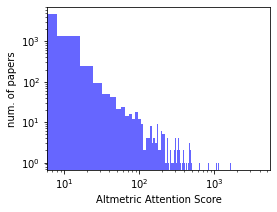

In [257]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(df_match.altmetric_score.tolist(), bins = 500, facecolor='blue', alpha=0.6)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim(0, 2000)
ax.set_xlabel('Altmetric Attention Score')
ax.set_ylabel('num. of papers')
plt.show()
fig.savefig(data_root+'score_dist.pdf', bbox_inches='tight', pad_inches=0.01)

Platform Weights:
    https://help.altmetric.com/support/solutions/articles/6000060969-how-is-the-altmetric-attention-score-calculated-

In [323]:
platform_stat = defaultdict(int)

for doi in doi_alt_data:
    paper = doi_alt_data[doi]
    for platform in paper['posts']:
        if paper['posts'][platform] != []:
            platform_stat[platform] += 1

In [324]:
sorted(platform_stat.items(), key=lambda x: -x[1])

[('twitter', 3969),
 ('blogs', 2587),
 ('peer_reviews', 1051),
 ('facebook', 736),
 ('patent', 665),
 ('news', 571),
 ('wikipedia', 316),
 ('f1000', 213),
 ('googleplus', 209),
 ('policy', 145),
 ('reddit', 100),
 ('video', 96),
 ('q&a', 18),
 ('misc', 14),
 ('weibo', 13),
 ('pinterest', 4),
 ('linkedin', 1)]

In [204]:
df_match.loc[df_match.altmetric_score > 1000][['OriginalPaperDOI', 'Title', 'Subject']]

,OriginalPaperDOI,Title,Subject
21,10.1001/jamainternmed.2018.3713,Association Between Physician Burnout and Pati...,(HSC) Medicine - General;(HSC) Occupational He...
306,10.1371/journal.pbio.1002593,Brain–Computer Interface–Based Communication i...,(B/T) Computer Science;(B/T) Technology;(BLS) ...
315,10.1080/15287394.2018.1477640,A lowered probability of pregnancy in females ...,(HSC) Medicine - Immunology;(HSC) Medicine - I...
420,10.1038/s41591-019-0459-6,CCR5-delta32 is deleterious in the homozygous ...,(BLS) Biology - Cellular;(BLS) Genetics;
448,10.1038/s41586-018-0651-8,Quantification of ocean heat uptake from chang...,(ENV) Climate Change;(ENV) Ground/Surface Water;
558,10.1016/j.cub.2015.09.056,The Negative Association between Religiousness...,(HUM) Religion;(SOC) Philosophy;(SOC) Psychology;
828,10.1016/s2213-8587(16)30085-7,Effect of a high-fat Mediterranean diet on bod...,(HSC) Medicine - General;(HSC) Nutrition;(HSC)...
855,10.1177/2047487317723212,Effect of marijuana use on cardiovascular and ...,(BLS) Toxicology;(HSC) Biostatistics/Epidemiol...
911,10.1001/jama.2018.12615,Association of Clinical Specialty With Symptom...,(HSC) Medicine - General;(HSC) Occupational He...
1023,10.1158/1055-9965.epi-17-0221,Night Shift Work Increases the Risks of Multip...,(HSC) Biostatistics/Epidemiology;(HSC) Medicin...


### Build time series data (use only English posts)

In [350]:
plat_cate = {
 'blogs': 'blog',
 'news': 'news_media',
 'patent': 'knowledge_repo',
 'f1000': 'knowledge_repo',
 'peer_reviews': 'knowledge_repo',
 'wikipedia': 'knowledge_repo',
 'q&a': 'knowledge_repo',
 'facebook': 'social_media',
 'googleplus': 'social_media',
 'linkedin': 'social_media',
 'pinterest': 'social_media',
 'reddit': 'social_media',
 'twitter': 'social_media',
 'video': 'social_media'
}

cates = ['social_media', 'blog', 'knowledge_repo', 'news_media', 'top_news']

In [550]:
def get_time_series_list(doi, category):
    paper = doi_alt_data[doi]
    time_li = []
    if 'posts' in paper:
        for plat in paper['posts']:
            # ignore misc.
            if plat in plat_cate:
                cate = plat_cate[plat]
                if cate == category:
                    for item in paper['posts'][plat]:
                        if plat == 'twitter':
                            tid = item['tweet_id']
                            # English tweets
                            if tid in tid_date:
                                time_li.append(tid_date[tid])
                        else:
                            if 'posted_on' in item:
                                tdate = item['posted_on'][:19]
                                text = ''
                                if 'title' in item and item['title']:
                                    text += item['title']
                                if 'summary' in item and item['summary']:
                                    text = text + ' ' + item['summary']
                                try:
                                    if detect(text) == 'en':
                                        time_li.append(tdate)
                                except:
                                    pass                   
    return sorted(time_li)

def get_top_news_time_series_list(doi):
    paper = doi_alt_data[doi]
    time_li = []
    if 'posts' in paper and 'news' in paper['posts']:
        for item in paper['posts']['news']:
            if 'posted_on' in item:
                tdate = item['posted_on'][:19]
                name = item['author']['name']
                # these top outlets are English language outlets, so we don't need to filter here.
                if name in top_outlets:
                    time_li.append(tdate)
    return sorted(time_li)

def get_uncertain_time_series_list(doi):
    paper = doi_alt_data[doi]
    time_li = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in uncertain_tids: # non retweet
                if tid in tid_date:
                    time_li.append(tid_date[tid])
            else: # might be retweet or original tweet but is normal tweet
                if tid in retweet_org_ids:
                    org_id = retweet_org_ids[tid]
                    if org_id in uncertain_tids and tid in tid_date:
                        time_li.append(tid_date[tid])
    return sorted(time_li)

def get_tweet_ids(doi):
    paper = doi_alt_data[doi]
    tids_li = []
    if 'posts' in paper and 'twitter' in paper['posts']:
        for item in paper['posts']['twitter']:
            tid = item['tweet_id']
            if tid in tid_date:
                tids_li.append(tid)
    return tids_li

def get_tw_follow_sort_date(tids):
    lii = []
    for tid in tids:
        lii.append((tid_date[tid], tid_follow_cn[tid]))
    return sorted(lii, key=lambda x: x[0])

def get_tw_date_sort(lli):
    return [dtt for (dtt, fcn) in lli]

def get_tw_fcn_date_sort(lli):
    return [fcn for (dtt, fcn) in lli]

In [546]:
df_match['news_media'] = df_match.OriginalPaperDOI.apply(get_time_series_list, args=['news_media'])
df_match['social_media'] = df_match.OriginalPaperDOI.apply(get_time_series_list, args=['social_media'])
df_match['blog'] = df_match.OriginalPaperDOI.apply(get_time_series_list, args=['blog'])
df_match['knowledge_repo'] = df_match.OriginalPaperDOI.apply(get_time_series_list, args=['knowledge_repo'])
df_match['top_news'] = df_match.OriginalPaperDOI.apply(get_top_news_time_series_list)

In [537]:
df_match['tweet_ids'] = df_match.OriginalPaperDOI.apply(get_tweet_ids)
df_match['date_tweet_fcn'] = df_match.tweet_ids.apply(get_tw_follow_sort_date)
df_match['tw_date_sort'] = df_match.date_tweet_fcn.apply(get_tw_date_sort)
df_match['fcn_date_sort'] = df_match.date_tweet_fcn.apply(get_tw_fcn_date_sort)
df_match = df_match.drop(columns=['date_tweet_fcn'])

In [552]:
df_match['uncertainty'] = df_match.OriginalPaperDOI.apply(get_uncertain_time_series_list)

In [551]:
len(df_match)

6680

In [547]:
df_match.head(2)

,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,RetractionDate,RetractionDOI,RetractionPubMedID,OriginalPaperDate,OriginalPaperDOI,OriginalPaperPubMedID,RetractionNature,Reason,Paywalled,Notes,altmetric_score,altmetric_pub_date,pub_date_corrected,usable_days,tweet_ids,tw_date_sort,fcn_date_sort,uncertainty,news_media,social_media,blog,knowledge_repo,top_news
0,23542,Hospital Admission and Readmission Among Homel...,(HSC) Medicine - Neurology;(SOC) Psychology;,Department of Neurology and Weill Institute fo...,Neurology,American Academy of Neurology,United States,Nicole Rosendale;Elan L Guterman;John P Betjem...,NaN,Research Article;,2020-06-04 00:00:00,10.1212/WNL.0000000000009565,32499376,2019-05-24 00:00:00,10.1212/wnl.0000000000007645,31127074,Retraction,+Concerns/Issues About Data;+Retract and Replace;,No,see: https://n.neurology.org/content/92/24/e2822,29.75,2019-05-24,2019-05-24 00:00:00,137,"[1133693569737187329, 1133763571790127106, 113...","[2019-05-29T11:16:24, 2019-05-29T15:54:34, 201...","[506, 273, 4836, 1845, 48163, 181, 935, 1322, ...",[],"[2019-05-28T15:33:34, 2019-05-28T18:38:39]","[2019-05-29T11:16:24, 2019-05-29T15:54:34, 201...",[],[],[]
1,23522,"DMA, a Bisbenzimidazole, Offers Radioprotectio...",(BLS) Biochemistry;(BLS) Biology - Cancer;(BLS...,Dr B. R. Ambedkar Center for Biomedical Resear...,PLoS One,PLoS,India;United States,Navrinder Kaur;Atul Ranjan;Vinod Tiwari;Ritu A...,NaN,Research Article;,2020-06-03 00:00:00,10.1371/journal.pone.0234365,32492047,2012-06-22 00:00:00,10.1371/journal.pone.0039426,22745752,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,NaN,0.50,2012-06-22,2012-06-22 00:00:00,2664,[219269442599784449],[2012-07-01T03:21:23],[803],[],[],[2012-07-01T03:21:23],[],[],[]


In [553]:
with open(data_root+'df_retract_clean.pickle', 'wb') as file:
    pickle.dump(df_match, file)

In [554]:
with open(data_root+'df_retract_clean.pickle', 'rb') as file:
    df_match = pickle.load(file)

In [555]:
# 6 months
np.sum(df_match.usable_days >= 180)

5464

In [389]:
min(df_match.RetractionDate)

datetime.datetime(1967, 6, 1, 0, 0)

In [360]:
df_match.OriginalPaperDate.value_counts().sort_index().head(1571)

1965-09-01    1
1967-06-01    1
1974-05-11    1
1980-10-01    1
1984-01-01    1
             ..
2011-11-13    1
2011-11-14    4
2011-11-15    2
2011-11-16    1
2011-11-18    1
Name: OriginalPaperDate, Length: 1571, dtype: int64